
## Project We Rate Dogs

## Table of Contents
- [Gathering](#Gathering)
- [Assessing](#Assessing)
- [Cleaning](#Cleaning)
- [Analyzing](#Analyzing)





## Load Data


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
import os
import json
import time
import seaborn as sns
import datetime
import re
import warnings
from IPython.display import Image
from functools import reduce
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

<a id='Gathering'></a>
## Gather

### Twitter Archive

In [64]:
#read csv as DataFrame

df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Image predictions

In [65]:
#Downloading URL programatically 
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

#Reading TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

### Twitter API and JSON

In [66]:
# Query Twitter API 
'''
auth = tweepy.OAuthHandler('', '')
auth.set_access_token('', '')
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


test=[]


tweet_ids= list(df_archive.tweet_id)
# Save each tweet's returned 
with open('tweet-json.txt', 'w') as outfile:
   
    for tweet_id in tweet_ids:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            x={'tweet_id':tweet.id,'retweet_count':tweet.retweet_count,
                                            'favorite_count':tweet.favorite_count}

            test.append(x)
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail", e)
            pass
'''            

'\nauth = tweepy.OAuthHandler(\'\', \'\')\nauth.set_access_token(\'\', \'\')\napi = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)\n\n\ntest=[]\n\n\ntweet_ids= list(df_archive.tweet_id)\n# Save each tweet\'s returned \nwith open(\'tweet-json.txt\', \'w\') as outfile:\n   \n    for tweet_id in tweet_ids:\n        try:\n            tweet = api.get_status(tweet_id, tweet_mode=\'extended\')\n            x={\'tweet_id\':tweet.id,\'retweet_count\':tweet.retweet_count,\n                                            \'favorite_count\':tweet.favorite_count}\n\n            test.append(x)\n            json.dump(tweet._json, outfile)\n            outfile.write(\'\n\')\n        except tweepy.TweepError as e:\n            print("Fail", e)\n            pass\n'

In [67]:
new_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        new_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_list_json = pd.DataFrame(new_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [68]:
tweet_list_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35168,7421,8942704,18,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30440,5518,8942704,18,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22885,3645,8942704,18,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38464,7595,8942704,18,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36723,8173,8942704,18,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


<a id='Assessing'></a>
## Assess


### Twitter archive

>Visual Inspection

In [69]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [70]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [71]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [72]:
df_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [73]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [74]:
#check for duplicates
print('Number of Duplicates = ' + str(sum(df_archive.duplicated())))

Number of Duplicates = 0


In [75]:
df_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [76]:
df_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [77]:
# Check if there are any records in twitter_arc which are retweets
print('Number of retweets = ' + str(len(df_archive[df_archive.retweeted_status_id.isnull() == False])))

Number of retweets = 181


In [78]:
# Sort by rating
df_archive.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [79]:
#Sort by rating_numerator
df_archive.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64


### OBSERVATIONS
#### Quality

    - tweet_id's are sometimes integers or floats (numeric)
    - "in_reply_to_staus_id, in_reply_to_user_id" and "retweeted_status_id, retweeted_status_user_id "are numeric
    - retweets are present in the data
    - "timestamp" and "retweeted_status_timestamp" are not a datetime variable
    - "source" values are formatted as <a> href=url <a/> 
    - rating_numerators and rating_denominator are integers instead of float
    - the dog names not standardized
    - timestamp column +0000  not necessary 
    - dog names contain: "'such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'"
    - there are 4 columns for doggo, floffer, pupper, and puppo but should be one column

##### Structure (tidyness)

    - more than one stage is filled for a particular dog
    - "source" and "expanded_urls" have several informations inside them
    - columns "doggo", "floofer", "pupper" and "puppo" refer to the same measurement unit, i.e, dog stage
    - there are 3 dataframes, only 1 dataframe should be needed



### Image Predictions
>Visual Inspection


In [80]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [81]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [82]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [83]:
image_prediction.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [84]:
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [85]:
#check for duplicates
print('Number of Duplicates = ' + str(sum(image_prediction.duplicated())))

Number of Duplicates = 0


In [86]:
image_prediction['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [87]:
image_prediction.img_num.unique()

array([1, 4, 2, 3], dtype=int64)

In [88]:
print('Number of Duplicates = '+ str(sum(image_prediction.jpg_url.duplicated()==True)))

Number of Duplicates = 66



### OBSERVATIONS
#### Quality

    -"tweet_id" and "tweet_id" are numeric and not categorical (string)
    - 2075 tweet ids present. archive dataset has 2356 ids, 2075 - 2356 = 281 IDs are missing)
    - p1, p2, and p3 contain underscores instead of spaces in the labels




### JSON file

In [89]:
tweet_list_json

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35168,7421,8942704,18,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30440,5518,8942704,18,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22885,3645,8942704,18,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38464,7595,8942704,18,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36723,8173,8942704,18,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3
...,...,...,...,...,...,...,...,...
2326,666049248165822465,94,38,8942725,18,Twitter for iPhone,Original tweet,https://t.co/4B7cOc1EDq
2327,666044226329800704,261,122,8942725,18,Twitter for iPhone,Original tweet,https://t.co/DWnyCjf2mx
2328,666033412701032449,107,39,8942725,18,Twitter for iPhone,Original tweet,https://t.co/y671yMhoiR
2329,666029285002620928,118,41,8942725,18,Twitter for iPhone,Original tweet,https://t.co/r7mOb2m0UI


In [90]:
tweet_list_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35168,7421,8942704,18,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30440,5518,8942704,18,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22885,3645,8942704,18,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38464,7595,8942704,18,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36723,8173,8942704,18,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [91]:
tweet_list_json.tail()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
2326,666049248165822465,94,38,8942725,18,Twitter for iPhone,Original tweet,https://t.co/4B7cOc1EDq
2327,666044226329800704,261,122,8942725,18,Twitter for iPhone,Original tweet,https://t.co/DWnyCjf2mx
2328,666033412701032449,107,39,8942725,18,Twitter for iPhone,Original tweet,https://t.co/y671yMhoiR
2329,666029285002620928,118,41,8942725,18,Twitter for iPhone,Original tweet,https://t.co/r7mOb2m0UI
2330,666020888022790149,2338,445,8942724,18,Twitter for iPhone,Original tweet,https://t.co/BLDqew2Ijj


In [92]:
tweet_list_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   favorite_count    2331 non-null   int64 
 2   retweet_count     2331 non-null   int64 
 3   followers_count   2331 non-null   int64 
 4   friends_count     2331 non-null   int64 
 5   source            2331 non-null   object
 6   retweeted_status  2331 non-null   object
 7   url               2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


In [93]:
tweet_list_json.describe()

,favorite_count,retweet_count,followers_count,friends_count
count,2331.000000,2331.000000,2.331000e+03,2331.0
mean,7345.906478,2607.959245,8.942714e+06,18.0
std,11408.774472,4412.233272,6.738392e+00,0.0
min,0.000000,1.000000,8.942703e+06,18.0
25%,1276.000000,529.000000,8.942707e+06,18.0
50%,3190.000000,1218.000000,8.942714e+06,18.0
75%,8989.500000,3026.000000,8.942716e+06,18.0
max,151336.000000,74912.000000,8.942725e+06,18.0


In [94]:
print('Number of Duplicates = '+ str(sum(tweet_list_json.duplicated()==True)))

Number of Duplicates = 0


<a id='Cleaning'></a>
## Clean

#### Storing Data to csv

In [95]:
# Make a copy 
df_archive_clean = df_archive.copy()
json_clean = tweet_list_json.copy()
df_image_clean = image_prediction.copy()

In [96]:
# Save a copy of the clean datasets to work with
df_archive_clean.to_csv('df_archive_clean.csv',encoding='utf-8',index=False)
df_image_clean.to_csv('df_image_clean.csv',encoding='utf-8',index=False)
json_clean.to_csv('json_clean.csv',encoding='utf-8',index=False)

In [97]:
# Load clean datasets
df_archive_clean = pd.read_csv('df_archive_clean.csv')
df_image_clean = pd.read_csv('df_image_clean.csv')
json_clean = pd.read_csv('json_clean.csv')

### Twitter Archive

>#### Define

>Replace all faulty names to none

In [98]:
df_archive_clean[df_archive_clean.name.str.islower()==True]['name'].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

>#### Code

In [99]:
none = ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
              'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
              'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
              'officially', 'life', 'light', 'space']
for x in none:
    df_archive_clean.name.replace(x, 'None',inplace=True)


>#### Test

In [100]:
df_archive_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Emmy',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra', 'Monkey',
       'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn', 'Boomer',
       'Cody', 'Rumble', 'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Cooper',
       'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Quinn', 'Belle', 'Zooe

In [101]:
df_archive.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept


>#### Define

>Assign 10 to rating_denominator column value


>#### Code

In [102]:
df_archive_clean.rating_denominator= df_archive_clean['rating_denominator']=10


>#### Test

In [103]:
df_archive_clean.rating_denominator.unique()

array([10], dtype=int64)

>#### Define
>Correctly extract the numberator information from text using a regex

>#### Code

In [104]:
rating = df_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
rating.columns = ['rating_numerator', 'rating_denominator']


>#### Test

In [105]:
rating.head()

,rating_numerator,rating_denominator
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10


>#### Define

>Convert timestamp to datetime format

>#### Code

In [106]:
#convert timestamp to datetime format
df_archive_clean['timestamp']= pd.to_datetime(df_archive_clean['timestamp'])
df_archive_clean['retweeted_status_timestamp']= pd.to_datetime(df_archive_clean['retweeted_status_timestamp'])


>#### Test

In [107]:
df_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


>#### Define

>Create the "dog_stage" column by combining columns "doggo", "floofer", "pupper" and "puppo"

>#### Code

In [108]:
#Create the "dog_stage" column by combining columns "doggo", "floofer", "pupper" and "puppo"
def dog_stage(row):
    stage = []
    if row['doggo'] == 'doggo':
        stage.append('doggo')
    if row['floofer'] == 'floofer':
        stage.append('floofer')
    if row['pupper'] == 'pupper':
        stage.append('pupper')
    if row['puppo'] == 'puppo':
        stage.append('puppo')
    
    if not stage:
        return "None"
    else:
        return ','.join(stage)
    
df_archive_clean['dog_stage'] = df_archive_clean.apply(lambda row: dog_stage(row), axis=1)


# drop the columns
df_archive_clean.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)



>#### Test



In [109]:
df_archive_clean.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None


In [110]:
pd.value_counts(df_archive_clean['dog_stage'])

None             1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: dog_stage, dtype: int64

>#### Define
>set tweet_id to string with astype()

>#### Code

In [111]:
#set tweet_id to string with astype()
df_archive_clean['tweet_id'] =df_archive_clean['tweet_id'].astype('str')


>#### Test

In [112]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Image Predictions

>#### Define
>Capitalize the first letter of names of p1,p2,p3 columns

>#### Code

In [113]:
#Capitalize the first letter of names of p1,p2,p3 columns
df_image_clean.p1= df_image_clean.p1.str.capitalize()
df_image_clean.p2= df_image_clean.p2.str.capitalize()
df_image_clean.p3= df_image_clean.p3.str.capitalize()

>#### Test

In [114]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [115]:
df_image_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


>#### Define 
>Replace _ and - with white space in p1,p2 and p3 columns

>#### Code

In [116]:
#Replace _ and - with white space in p1,p2 and p3 columns
df_image_clean.p1= df_image_clean.p1.str.replace('_',' ')
df_image_clean.p2= df_image_clean.p2.str.replace('_',' ')
df_image_clean.p3= df_image_clean.p3.str.replace('_',' ')

df_image_clean.p1= df_image_clean.p1.str.replace('-',' ')
df_image_clean.p2= df_image_clean.p2.str.replace('-',' ')
df_image_clean.p3= df_image_clean.p3.str.replace('-',' ')

>#### Test

In [117]:
df_image_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,Collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,Redbone,0.360687,True,Miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


>#### Define
>set tweet_id to string with astype()

>#### Code

In [118]:
#set tweet_id to string with astype()
df_image_clean['tweet_id'] =df_image_clean['tweet_id'].astype('str')


>#### Test

In [119]:
df_image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### JSON file

>#### Define
>set tweet_id to string with astype()

>#### Code

In [120]:
#set tweet_id to string with astype()
tweet_list_json['tweet_id'] =tweet_list_json['tweet_id'].astype('str')


>#### Test

In [121]:
tweet_list_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   favorite_count    2331 non-null   int64 
 2   retweet_count     2331 non-null   int64 
 3   followers_count   2331 non-null   int64 
 4   friends_count     2331 non-null   int64 
 5   source            2331 non-null   object
 6   retweeted_status  2331 non-null   object
 7   url               2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


>#### Define
>Renaming the column names

>#### Code

In [122]:
#Renaming the column names
tweet_list_json.rename(columns={ 'followers_count': 'followers','friends_count':'friends','favorite_count': 'likes', 'retweet_count': 'retweets', 'source': 'device'}, inplace=True)


>#### Test

In [123]:
tweet_list_json.describe()

,likes,retweets,followers,friends
count,2331.000000,2331.000000,2.331000e+03,2331.0
mean,7345.906478,2607.959245,8.942714e+06,18.0
std,11408.774472,4412.233272,6.738392e+00,0.0
min,0.000000,1.000000,8.942703e+06,18.0
25%,1276.000000,529.000000,8.942707e+06,18.0
50%,3190.000000,1218.000000,8.942714e+06,18.0
75%,8989.500000,3026.000000,8.942716e+06,18.0
max,151336.000000,74912.000000,8.942725e+06,18.0


>#### Define
>Set the column order

>#### Code

In [124]:
#Set the column order
tweet_list_json = tweet_list_json[['tweet_id', 'followers', 'friends', 
                                   'retweets', 'likes', 'retweeted_status', 'device', 'url']]


>#### Test

In [125]:
tweet_list_json.head()

,tweet_id,followers,friends,retweets,likes,retweeted_status,device,url
0,892420643555336193,8942704,18,7421,35168,Original tweet,Twitter for iPhone,https://t.co/MgUWQ76dJU
1,892177421306343426,8942704,18,5518,30440,Original tweet,Twitter for iPhone,https://t.co/aQFSeaCu9L
2,891815181378084864,8942704,18,3645,22885,Original tweet,Twitter for iPhone,https://t.co/r0YlrsGCgy
3,891689557279858688,8942704,18,7595,38464,Original tweet,Twitter for iPhone,https://t.co/tD36da7qLQ
4,891327558926688256,8942704,18,8173,36723,Original tweet,Twitter for iPhone,https://t.co/0g0KMIVXZ3


### Combine DataSets



>#### Define
>Merge datasets into one

>#### Test

In [126]:
#merge datasets
df_merged = pd.merge(df_archive_clean, df_image_clean, on=['tweet_id'], how='inner')
df_merged = pd.merge(df_merged, tweet_list_json, on = 'tweet_id', how = 'inner' )


>#### Code

In [127]:
df_merged.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p3,p3_conf,p3_dog,followers,friends,retweets,likes,retweeted_status,device,url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,Banana,0.076110,False,8942704,18,7421,35168,Original tweet,Twitter for iPhone,https://t.co/MgUWQ76dJU
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,Papillon,0.068957,True,8942704,18,5518,30440,Original tweet,Twitter for iPhone,https://t.co/aQFSeaCu9L
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,...,Kelpie,0.031379,True,8942704,18,3645,22885,Original tweet,Twitter for iPhone,https://t.co/r0YlrsGCgy
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,...,Spatula,0.040836,False,8942704,18,7595,38464,Original tweet,Twitter for iPhone,https://t.co/tD36da7qLQ
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,...,German short haired pointer,0.175219,True,8942704,18,8173,36723,Original tweet,Twitter for iPhone,https://t.co/0g0KMIVXZ3


>#### Define
>Calulate the value of 'rating'

>#### Code

In [128]:
# Calulate the value of 'rating'
df_merged['rating'] = df_merged['rating_numerator'] / df_merged['rating_denominator']


>#### Test

In [129]:
df_merged.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p3_conf,p3_dog,followers,friends,retweets,likes,retweeted_status,device,url,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,0.07611,False,8942704,18,7421,35168,Original tweet,Twitter for iPhone,https://t.co/MgUWQ76dJU,1.3


>#### Define
>Drop columns 

>#### Code

In [130]:
# Drop columns 
df_merged.drop(['in_reply_to_status_id', 
                  'in_reply_to_user_id',
                  'img_num',
                  'source',
                  'url'], axis = 1, inplace=True)


>#### Test

In [131]:
df_merged.head(1)

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,...,p3,p3_conf,p3_dog,followers,friends,retweets,likes,retweeted_status,device,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,Banana,0.07611,False,8942704,18,7421,35168,Original tweet,Twitter for iPhone,1.3


>#### Define
>Renaming columns

>#### Code

In [132]:
#renaming columns
df_merged.rename(columns={ 'rating_numerator': 'numerator','rating_denominator':'denominator',}, inplace=True)
df_merged['dog_breed'] = 'None'
for i, row in df_merged.iterrows():

    if row.p1_dog:
        #dfs.set_value(i, 'dog_breed', row.p1)
        df_merged.at[i, 'dog_breed'] = row.p1
    elif row.p2_dog and row.numerator >= 10:
        #dfs.set_value(i, 'dog_breed', row.p2)
        df_merged.at[i, 'dog_breed'] = row.p2
    elif row.p3_dog and row.numerator >= 10:
        #dfs.set_value(i, 'dog_breed', row.p3)
        df_merged.at[i, 'dog_breed'] = row.p3
    else:
        #dfs.set_value(i, 'dog_breed', 'None')
        df_merged.at[i, 'dog_breed'] = 'None'


>#### Test

In [133]:
df_merged.head()

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,numerator,denominator,name,...,p3_conf,p3_dog,followers,friends,retweets,likes,retweeted_status,device,rating,dog_breed
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,0.076110,False,8942704,18,7421,35168,Original tweet,Twitter for iPhone,1.3,None
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,0.068957,True,8942704,18,5518,30440,Original tweet,Twitter for iPhone,1.3,Chihuahua
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,0.031379,True,8942704,18,3645,22885,Original tweet,Twitter for iPhone,1.2,Chihuahua
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,0.040836,False,8942704,18,7595,38464,Original tweet,Twitter for iPhone,1.3,Labrador retriever
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,0.175219,True,8942704,18,8173,36723,Original tweet,Twitter for iPhone,1.2,Basset


### Writing New Data Set 

In [134]:
df_merged.to_csv('twitter_master.csv', encoding='utf-8',index=False)
df_wrangled= pd.read_csv('twitter_master.csv')
df_wrangled.head()

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,numerator,denominator,name,...,p3_conf,p3_dog,followers,friends,retweets,likes,retweeted_status,device,rating,dog_breed
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,0.076110,False,8942704,18,7421,35168,Original tweet,Twitter for iPhone,1.3,None
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,0.068957,True,8942704,18,5518,30440,Original tweet,Twitter for iPhone,1.3,Chihuahua
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,0.031379,True,8942704,18,3645,22885,Original tweet,Twitter for iPhone,1.2,Chihuahua
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,0.040836,False,8942704,18,7595,38464,Original tweet,Twitter for iPhone,1.3,Labrador retriever
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,0.175219,True,8942704,18,8173,36723,Original tweet,Twitter for iPhone,1.2,Basset


<a id='Analyzing'></a>
## Analyze

>List of dog ratings greater than 6

In [135]:
df_wrangled.loc[df_wrangled['rating'] > 6]

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,numerator,denominator,name,...,p3_conf,p3_dog,followers,friends,retweets,likes,retweeted_status,device,rating,dog_breed
336,820690176645140481,2017-01-15 17:52:40+00:00,The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,10,None,...,0.037400,True,8942706,18,3162,12042,Original tweet,Twitter for iPhone,8.4,West highland white terrier
548,786709082849828864,2016-10-13 23:23:56+00:00,"This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,...,0.102654,True,8942709,18,6038,18063,Original tweet,Twitter for iPhone,7.5,Pomeranian
722,758467244762497024,2016-07-28 01:00:57+00:00,Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,10,None,...,0.099689,True,8942712,18,2158,4681,Original tweet,Twitter for iPhone,16.5,Labrador retriever
789,749981277374128128,2016-07-04 15:00:45+00:00,This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,...,0.050776,False,8942712,18,2393,4971,Original tweet,TweetDeck,177.6,None
911,731156023742988288,2016-05-13 16:15:54+00:00,Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,10,None,...,0.049444,False,8942714,18,1219,3711,Original tweet,Twitter for iPhone,20.4,None
1009,713900603437621249,2016-03-27 01:29:02+00:00,Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,10,None,...,0.092725,True,8942715,18,702,2742,Original tweet,Twitter for iPhone,9.9,Golden retriever
1034,710658690886586372,2016-03-18 02:46:49+00:00,Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,10,None,...,0.015943,True,8942715,18,540,2234,Original tweet,Twitter for iPhone,8.0,Soft coated wheaten terrier
1366,684225744407494656,2016-01-05 04:11:44+00:00,"Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,10,None,...,0.065327,True,8942715,18,197,1199,Original tweet,Twitter for iPhone,14.3,Golden retriever
1367,684222868335505415,2016-01-05 04:00:18+00:00,Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,10,None,...,0.071486,False,8942715,18,1308,3709,Original tweet,Twitter for iPhone,12.1,Soft coated wheaten terrier
1498,677716515794329600,2015-12-18 05:06:23+00:00,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677716515...,144,10,None,...,0.025438,True,8942716,18,930,2904,Original tweet,Twitter for iPhone,14.4,Chow


### Cloud Words
>Create a function to remove http:// and followed links for cloud words.

In [136]:
def link_remover(x):
        http = x.find("http")
        if http == -1:
            x = x
        else:
            x = x[:http - 1]
        return x
df_wrangled.text = df_wrangled.text.apply(link_remover)
for row in df_wrangled.text[:20]:
    print(row)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek
Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek
Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below

When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10
This is Zoey. She doesn't want to be one of the scary shark

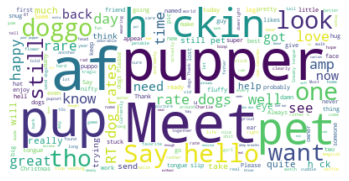

In [137]:
text1 = " ".join(review for review in df_wrangled.text) #to collect all texts from column 'text' in df_result
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["puppy", "Bruno", "dog", "good", "boy", 'cool'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text1)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Scatter Plot of Retweets vs Favorites

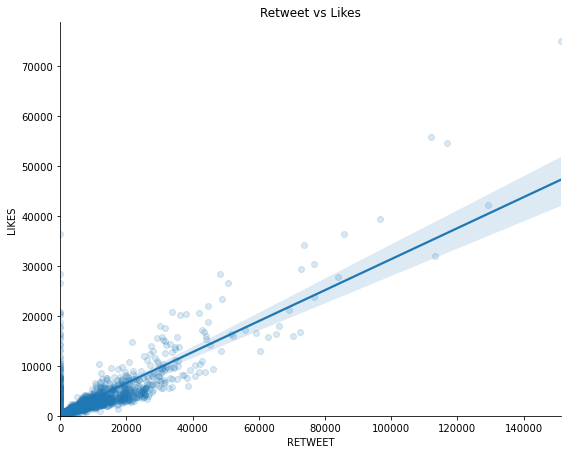

In [138]:
# Plot scatterplot of retweet vs favorite count
import seaborn as sns
visual = sns.lmplot(x="likes", 
           y="retweets", 
           data=tweet_list_json,
           height = 6,
           aspect=1.3,
           scatter_kws={'alpha':1/6});
axes = visual.axes
axes[0,0].set_xlim(0,);
axes[0,0].set_ylim(0,);
plt.title('Retweet vs Likes');
plt.xlabel('RETWEET');
plt.ylabel('LIKES');

In [139]:
df_wrangled.retweets.describe()

count     2059.000000
mean      2493.766877
std       4357.608977
min         11.000000
25%        534.500000
50%       1178.000000
75%       2863.500000
max      74912.000000
Name: retweets, dtype: float64

>Likes increase as Retweets Increase

### Histogram of Retweets

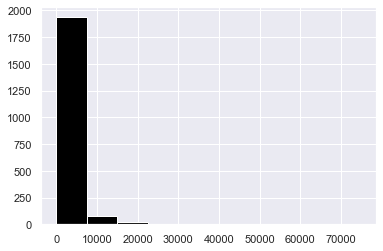

In [140]:
def set_palette():
    sns.set()
    current_palette = sns.color_palette(my_palette)
    sns.set_palette(current_palette)

my_palette = ['#000000']
set_palette()
df_wrangled.retweets.hist();



#### Subset of Retweets

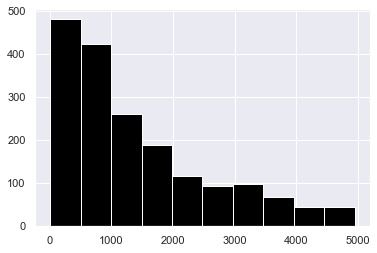

In [141]:
df_wrangled[df_wrangled.retweets <= 5000].retweets.hist();

### Line Graph of Weekly Retweets and Favorites

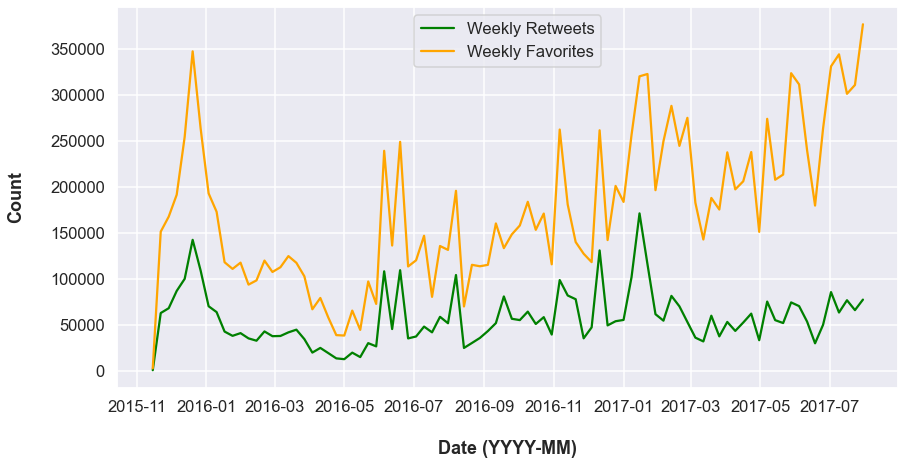

In [142]:
df_wrangled['timestamp'] = pd.to_datetime(df_wrangled.timestamp)
weeklyRT = df_wrangled.groupby(pd.Grouper(key='timestamp', freq='1w'))['retweets'].sum()\
                    .reset_index().sort_values('timestamp')[:-1]

weekly_favorite = df_wrangled.groupby(pd.Grouper(key='timestamp', freq='1w'))['likes'].sum()\
                    .reset_index().sort_values('timestamp')[:-1]

sns.set_context("talk")
plt.subplots(figsize=(14, 7))
plt.plot(weeklyRT.timestamp, weeklyRT.retweets, label="Weekly Retweets", color="green")
plt.plot(weekly_favorite.timestamp, weekly_favorite.likes, label="Weekly Favorites", color="orange")
plt.xlabel('\nDate (YYYY-MM)', weight='bold')
plt.ylabel('Count\n', weight='bold')
plt.legend();

### Comparing Retweets and Favorites Years

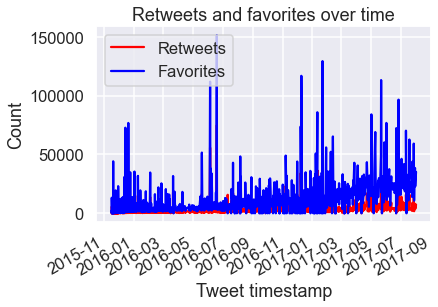

In [143]:
timestamp_df = df_wrangled[['timestamp', 'retweets', 'likes', 'numerator', 'denominator']].copy()
# Set the index to be the timestamp so time is displayed properly in plots
timestamp_df.set_index('timestamp', inplace=True)

timestamp_df['retweets'].plot(color = 'red', label='Retweets')
timestamp_df['likes'].plot(color = 'blue', label='Favorites')
plt.rcParams["figure.figsize"]=(14, 14)
plt.legend(loc='upper left')
plt.xlabel('Tweet timestamp')
plt.ylabel('Count')
plt.title('Retweets and favorites over time')
plt.show()